#Loading word embeddings


In [3]:
import io
import numpy as np

In [4]:
data_path = '/home/Gender_Bias/Gender_Bias_Ro/'

In [5]:
def load_vec(emb_path, nmax=10000000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [6]:
def save_vec(embeddings, id2word, emb_path):
    with io.open(emb_path, 'w', encoding='utf-8', newline='\n', errors='ignore') as f:
        f.write('50000 300\n')
        for i in range(len(embeddings)):
            f.write(id2word[i]+' ')
            for number in embeddings[i]:
                f.write(str(number)+' ')
            f.write('\n')

In [7]:
romanian_path = data_path + 'embeddings_ro/wiki.multi.ro.vec'
nmax = 1000000  # maximum number of word embeddings to load
romanian_embeddings, romanian_id2word, romanian_word2id = load_vec(romanian_path, nmax)

#Calculate cosine similarity

In [8]:
def cos_sim(emb1, emb2):
    return((emb1/np.linalg.norm(emb1)).dot(emb2/np.linalg.norm(emb2)))

def get_cos_sim(word1, src_emb, src_id2word, word2, tgt_emb, tgt_id2word):
    word2id_1 = {v: k for k, v in src_id2word.items()}
    emb_1 = src_emb[word2id_1[word1]]
    word2id_2 = {v: k for k, v in tgt_id2word.items()}
    emb_2 = tgt_emb[word2id_2[word2]] 
    return((emb_1/np.linalg.norm(emb_1)).dot(emb_2/np.linalg.norm(emb_2)))

def get_cos_sim_neutral(word, emb, id2word):
    word2id = {v: k for k, v in id2word.items()}
    print(word2id)
    word_emb = emb[word2id[word]]
    return((neutral_embedding/np.linalg.norm(neutral_embedding)).dot(word_emb/np.linalg.norm(word_emb)))

#Read in female and male occupations

In [10]:
female_occupations = []
with open(data_path + 'data_ro/RO_occupation_words_with_EN_translations','r') as file:
    for line in file:
        female_occupations.append(line.split('\t')[0])

male_occupations = []
with open(data_path + 'data_ro/RO_occupation_words_with_EN_translations','r') as file:
    for line in file:
        male_occupations.append(line.split('\t')[1])

print(female_occupations[:10])
print(male_occupations[:10])

['operatoare', 'tehniciană', 'angajată', 'directoare', 'ingineră', 'mecanică', 'șoferiță', 'administratoare', 'antrenoare', 'crainică']
['operator', 'tehnician', 'angajat', 'director', 'inginer', 'mecanic', 'șofer', 'administrator', 'antrenor', 'crainic']


#Get Gender Directions

In [11]:
from sklearn.decomposition import PCA

def doPCA(pairs, embedding, word2id, num_components = 10):
    matrix = []
    for a, b in pairs:
        if a not in word2id or b not in word2id:
            # skip words that were not found
            continue
        center = (embedding[word2id[a]] + embedding[word2id[b]]/2)
        matrix.append(embedding[word2id[a]] - center)
        matrix.append(embedding[word2id[b]] - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    return pca

def doPCA_multi(pairs, embedding1, embedding2, word2id1, word2id2, num_components = 10):
    matrix = []
    count = 0
    for a, b in pairs:
        if count < 10:
            embedding = embedding1
            word2id = word2id1
        else:
            embedding = embedding2
            word2id = word2id2
        
        center = (embedding[word2id[a]] + embedding[word2id[b]]/2)
        matrix.append(embedding[word2id[a]] - center)
        matrix.append(embedding[word2id[b]] - center)
        count += 1
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    return pca

##Romanian

In [13]:
import json
with open(data_path + 'data_ro/RO_definitional_pairs.json', "r") as f:
    RO_defs = json.load(f)

RO_gender_direction = doPCA(RO_defs, romanian_embeddings, romanian_word2id).components_[0]

In [14]:
RO_defs

[['femeie', 'bărbat'],
 ['fetiță', 'băiețel'],
 ['ea', 'el'],
 ['mamă', 'tata'],
 ['fiică', 'fiu'],
 ['fată', 'băiat'],
 ['soră', 'frate'],
 ['verișoară', 'verișor'],
 ['nepoata', 'nepot'],
 ['soție', 'soț']]

#Get Grammatical and Semantic Gender Directions

In [15]:
'''
read masculine nouns and feminine nouns
'''
RO_masculine_nouns = []
RO_feminine_nouns = []
with open(data_path + "data_ro/masculine_nouns_ro.txt", "r") as f:
    for line in f:
        line = line.strip()
        word = line #[3:]
        # print(word)
        if word not in RO_masculine_nouns:
            RO_masculine_nouns.append(word)

#print(len(masculine_nouns))

with open(data_path + "data_ro/feminine_nouns_ro.txt", "r") as f:
    for line in f:
        line = line.strip()
        word = line #[3:]
        if word not in RO_feminine_nouns:
            RO_feminine_nouns.append(word)

#print(len(ES_feminine_nouns))

RO_grammar_pair_new = []
for f,m in zip(RO_feminine_nouns, RO_masculine_nouns):
    pair = [f,m]
    RO_grammar_pair_new.append(pair)
    
len(RO_grammar_pair_new)

4000

In [18]:
'''
grammatical gender direction
'''
def doPCA_grammatical1(pairs, embedding, word2id, num_components = 10):
    matrix = []
    female_sum = np.zeros(300)
    male_sum = np.zeros(300)
    for a, b in pairs:
        female_sum += embedding[word2id[a]]
        male_sum += embedding[word2id[b]]

    return (male_sum-female_sum)

def doPCA_grammatical2(pairs, embedding, word2id, num_components = 10):
    matrix = []
    skipped_words = 0
    all_words = 0
    female_sum = np.zeros(300)
    male_sum = np.zeros(300)
    center =np.zeros(300)
    for a, b in pairs:
        if a not in word2id or b not in word2id:
            # skip words that are not found in embeddings
            skipped_words += 1
            continue
        center += (embedding[word2id[a]] + embedding[word2id[b]])/2
        female_sum += embedding[word2id[a]] 
        male_sum += embedding[word2id[b]] 
        all_words += 1
    matrix.append(female_sum - center)
    matrix.append(male_sum - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    print("Number of words: ", all_words)
    return pca

# we take a number of 3452 words to calculate exactly with 3000 words that are found in the4 embeddings
RO_grammar_gender_direction_new = -doPCA_grammatical2(RO_grammar_pair_new[:3452], romanian_embeddings, romanian_word2id, 2).components_[0]


Number of words:  3000


In [19]:
cos_sim(RO_grammar_gender_direction_new, RO_gender_direction)

0.4764658200845507

#Train a Classifier to Get the Grammatical Gender Direction

##Romanian

In [20]:
RO_expanded_m_nouns = []
RO_expanded_f_nouns = []
with open(data_path + "data_ro/masculine_nouns_ro.txt", "r") as f:
    for line in f:
        word = line.strip()
        # word = line[3:]
        if word not in RO_expanded_m_nouns:
            if word not in romanian_word2id.keys():
                # print(word)
                continue
            RO_expanded_m_nouns.append(word)

print(len(RO_expanded_m_nouns))

with open(data_path + "data_ro/feminine_nouns_ro.txt", "r") as f:
    for line in f:
        word = line.strip()
        # word = line[3:]
        if word not in RO_expanded_f_nouns:
            if word not in romanian_word2id.keys():
                # print(word)
                continue
            RO_expanded_f_nouns.append(word)

print(len(RO_expanded_f_nouns))

RO_grammar_pair_expanded = []
for f,m in zip(RO_expanded_f_nouns, RO_expanded_m_nouns):
    pair = [f,m]
    RO_grammar_pair_expanded.append(pair)
    
len(RO_grammar_pair_expanded)

3534
3738


3534

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
clf_kfold = LinearSVC()

In [23]:
shortened_3000 = RO_grammar_pair_expanded[:3000]
shortened_2000 = RO_grammar_pair_expanded[:2000]
shortened_1000 = RO_grammar_pair_expanded[:1000]
shortened_500 = RO_grammar_pair_expanded[:500]
shortened_100 = RO_grammar_pair_expanded[:100]
shortened_50 = RO_grammar_pair_expanded[:50]

In [24]:
used_word_count = 3000

In [25]:
X_3000 = np.zeros((used_word_count * 2, 300))
counter = 0
for pair in shortened_3000:
    X_3000[counter] = romanian_embeddings[romanian_word2id[pair[0]]]
    counter += 1
    X_3000[counter] = romanian_embeddings[romanian_word2id[pair[1]]]
    counter += 1

y_3000 = np.tile([1,2],used_word_count)

scores_3000 = cross_val_score(clf_kfold, X_3000, y_3000, cv=5)
print("Accuracy: %0.4f (+/- %0.5f)" % (scores_3000.mean(), scores_3000.std() * 2))

clf_3000 = LinearSVC()
clf_3000.fit(X_3000, y_3000)
#cos_sim(np.reshape(clf_3000.coef_, (300,)), np.reshape(clf_3000.coef_, (300,)))

coef = clf_3000.coef_
RO_grammar_gender_direction_3000 = np.reshape(coef/np.linalg.norm(coef), (300,))

Accuracy: 0.9773 (+/- 0.00785)


In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf_LDA = LinearDiscriminantAnalysis(n_components=1)

scores_3000 = cross_val_score(clf_LDA, X_3000, y_3000, cv=5)
print("Accuracy: %0.4f (+/- %0.5f)" % (scores_3000.mean(), scores_3000.std() * 2))

clf_LDA.fit(X_3000, y_3000)

coef = clf_LDA.coef_
RO_grammar_gender_direction_LDA_3000 = np.reshape(coef/np.linalg.norm(coef), (300,))

Accuracy: 0.9780 (+/- 0.00786)


In [27]:
cos_sim(RO_grammar_gender_direction_3000, RO_grammar_gender_direction_LDA_3000)

0.9538432679305747

In [28]:
cos_sim(RO_grammar_gender_direction_3000, RO_gender_direction)

0.5315660313718016

In [29]:
# Semantic Gender Directions
from numpy import linalg as LA
def drop(u, v):
    return u - v * u.dot(v) / v.dot(v)

# Get semantic gender component for a vector by removing the grammatical gender component
def get_SG_component(vector, ggd):
    return vector - (vector.dot(ggd)*ggd/ggd.dot(ggd))

RO_semantic_gender_direction = get_SG_component(RO_gender_direction, RO_grammar_gender_direction_3000)

print(cos_sim(RO_semantic_gender_direction, RO_gender_direction))

0.8470168559666527


In [30]:
RO_semantic_gender_direction_LDA = get_SG_component(RO_gender_direction, RO_grammar_gender_direction_LDA_3000)

In [31]:
cos_sim(RO_semantic_gender_direction, RO_semantic_gender_direction_LDA)

0.9823539149158289

##Visualisation

In [32]:
import matplotlib.pyplot as plt

def plot_on_gender_dir_pairs(pairs, embeddings, word2id, gender_direction):
    x_coords = []
    y_coords = list(range((len(pairs))*2))
    word_labels = []
    for pair in pairs:
        if pair[0] in word2id and pair[1] in word2id:
            x_coords.append(embeddings[word2id[pair[0]]].dot(gender_direction))
            word_labels.append(pair[0])
            x_coords.append(embeddings[word2id[pair[1]]].dot(gender_direction))
            word_labels.append(pair[1])
        else:
            print(pair[0])
    # display scatter plot
    fig=plt.figure(figsize=(10, 9), dpi=80)
    print(x_coords, y_coords)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'red' if k%2==0 else 'blue'  # masculine words in blue / feminine words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(min(x_coords) - 0.2, max(x_coords) + 0.2)
    plt.ylim(0 - 2, 20 + 2)
    plt.title('Visualization of words on gender direction')

    plt.show()
    #fig.savefig('Occupation_on_gender_direction')

[-0.1875323181152208, 0.08031279775072286, -0.2016106260443118, 0.08553964427085463, -0.15649507684502836, 0.03889543779348971, -0.13480966305527567, 0.04313665362536605, -0.19139103991062112, 0.11867365261184358, -0.21441311026563029, 0.10412960461497503, -0.2263782990183913, 0.044080393428188785, -0.1777122501196697, 0.019184002315775085, -0.0949192743245635, 0.0882311008733962, -0.20271784482648564, 0.017344325361265855] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


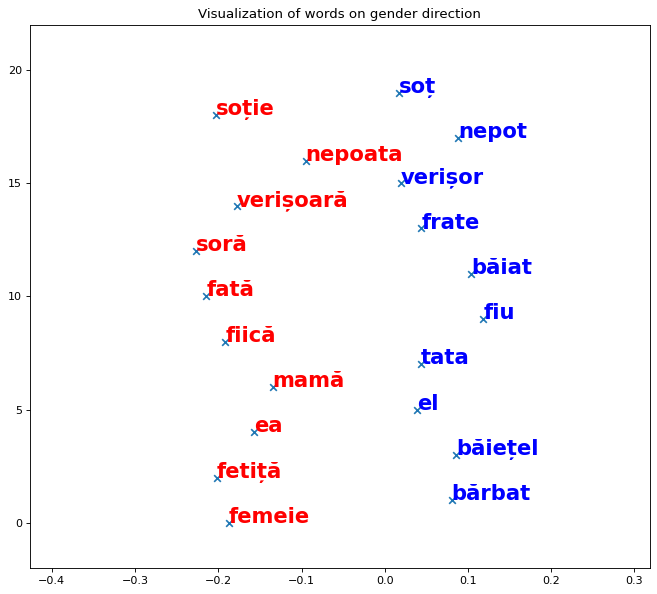

In [34]:
plot_on_gender_dir_pairs(RO_defs, romanian_embeddings, romanian_word2id, RO_grammar_gender_direction_3000)

[0.031114937690280706, -0.07568949953607089, 0.037725154162959434, 0.001147504984346469, -0.06567864481216196, 0.019789435303783937, -0.026002476208385347, 0.01698677454543702, 0.04797940649668714, -0.017141126288194537, 0.017743760251439172, 0.008092943957939917, 0.02363028905127949, 0.0038038862583584304, -0.03181971709423466, -0.021506408246544866, 0.06897614945268013, 0.08743806478091096, -0.034504959544323886, 0.0028396381225562453] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


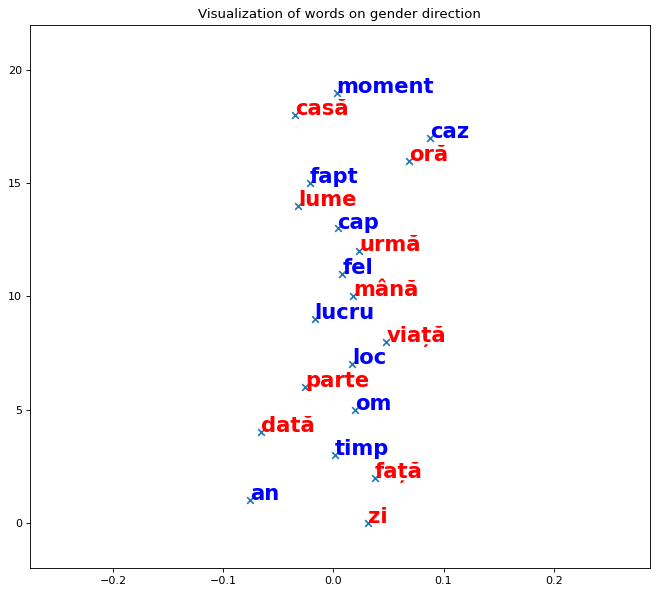

In [35]:
plot_on_gender_dir_pairs(RO_grammar_pair_new[:10], romanian_embeddings, romanian_word2id, RO_semantic_gender_direction) 

[0.09116833440847744, -0.15268048506895457, 0.04362727218063113, -0.24038661105790676, 0.050354568461086685, -0.17079311311435705, 0.025336066756431314, -0.13655834478542347, 0.0031173694035166537, -0.14705079023342285, 0.013610686826941847, -0.12596661086142827, -0.0007389610434564053, -0.13789944432246495, 0.09274900069483434, -0.10528559466325564, 0.07775115531408572, -0.14566574051909958, 0.05252028767150786, -0.027671036490599463] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


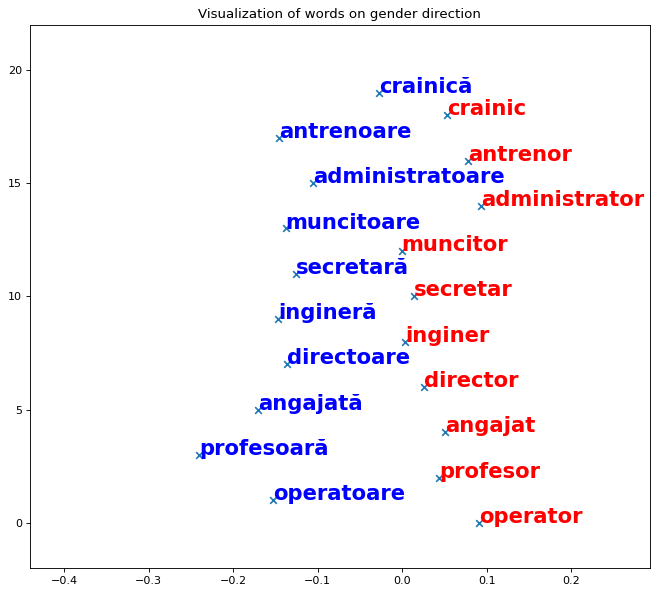

In [36]:
combined_occupation_words = [['operatoare', 'operator','operator'], ['profesoară', 'profesor','professor'], ['angajată','angajat', 'employee'], ['directoare','director', 'director'], 
                            ['ingineră','inginer','engineer'],['secretară', 'secretar', 'registrar'], ['muncitoare', 'muncitor', 'worker'], ['administratoare', 'administrator', 'admin'], 
                            ['antrenoare', 'antrenor', 'trainer'], ['crainică', 'crainic', 'announcer']]
both_version_words = [['el', 'ea','he','she'], ['chelneriță', 'chelner', 'waiter', 'waitress']]
RO_occupation_words_new = [[triple[1], triple[0]] for triple in combined_occupation_words]

plot_on_gender_dir_pairs(RO_occupation_words_new, romanian_embeddings, romanian_word2id, RO_semantic_gender_direction)

#Plot on both Gender Direction and Grammatical Gender Direction

In [37]:
RO_plot_pairs = [['lume(world)', 'cuvânt(word)'], ['bucătăreasă(cook_f)', 'bucătar(cook_m)'], \
                ['avocată(lawyer_f)', 'avocat(lawyer_m)'],  ['inginera(engineer_f)', 'inginer(engineer_m)'], 
                 ['angajată(employee_f)', 'angajat(employee_m)'], \
                 ['apa(water)','drum(road)'], ['ea(she)','el(he)']]

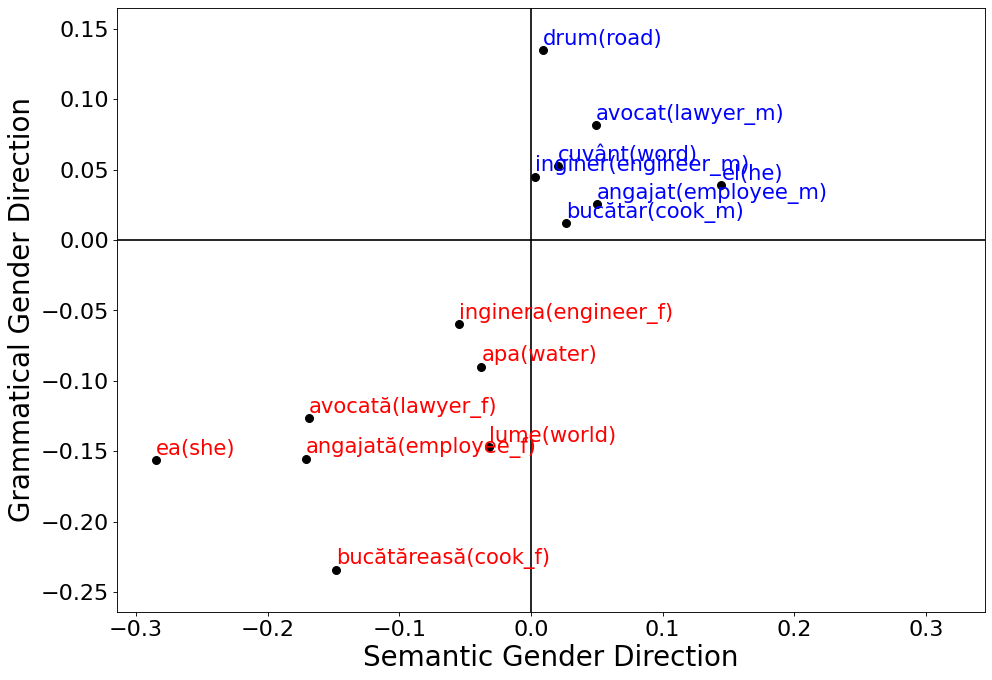

In [38]:
def plot_on_both_dir_pairs(pairs, embeddings, word2id, gender_direction, grammatical_gender_direction):
    x_coords = []
    y_coords = []
    word_labels = []
    counter = 0
    for pair in pairs:
        f_word = pair[0].split('(')[0]
        m_word = pair[1].split('(')[0]
        x_coords.append(embeddings[word2id[f_word]].dot(gender_direction))
        y_coords.append(embeddings[word2id[f_word]].dot(grammatical_gender_direction))
        word_labels.append(pair[0])
        x_coords.append(embeddings[word2id[m_word]].dot(gender_direction))
        y_coords.append(embeddings[word2id[m_word]].dot(grammatical_gender_direction))
        word_labels.append(pair[1])
    # display scatter plot
    fig=plt.figure(figsize=(14, 10), dpi=80)
    plt.scatter(x_coords, y_coords, s=50,marker='o',c='black')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'red' if k%2==0 else 'blue'  # masculine words in blue / feminine words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 5), textcoords='offset points', fontsize=19, 
                     color=color) # weight='bold'

    plt.xlim(min(x_coords) - 0.03, max(x_coords) + 0.2)
    plt.ylim(min(y_coords) - 0.03, max(y_coords) + 0.03)
    #plt.title('Visualization of occupation words on gender direction')
    plt.xlabel('Semantic Gender Direction', fontsize=25)
    plt.ylabel('Grammatical Gender Direction', fontsize=25)
    plt.tick_params(labelsize=20)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    
    plt.show()
    fig.savefig('viz_2directions_new.pdf',bbox_inches='tight')
    

plot_on_both_dir_pairs(RO_plot_pairs, romanian_embeddings, romanian_word2id, RO_semantic_gender_direction, RO_grammar_gender_direction_3000)



In [39]:
RO_occupation_pairs = []
for i in range(len(female_occupations)):
    if female_occupations[i] in romanian_word2id and male_occupations[i] in romanian_word2id:
        RO_occupation_pairs.append([female_occupations[i], male_occupations[i]])
print(RO_occupation_pairs)

[['operatoare', 'operator'], ['angajată', 'angajat'], ['directoare', 'director'], ['ingineră', 'inginer'], ['mecanică', 'mecanic'], ['administratoare', 'administrator'], ['antrenoare', 'antrenor'], ['crainică', 'crainic'], ['arhitectă', 'arhitect'], ['astronomă', 'astronom'], ['chelneriță', 'chelner'], ['angajată', 'angajat'], ['responsabilă', 'responsabil'], ['chimistă', 'chimist'], ['coregrafă', 'coregraf'], ['cercetătoare', 'cercetător'], ['profesoară', 'profesor'], ['muncitoare', 'muncitor'], ['bucătăreasă', 'bucătar'], ['consilieră', 'consilier'], ['secretară', 'secretar'], ['conservatoare', 'conservator'], ['dansatoare', 'dansator'], ['desenatoare', 'desenator'], ['editoare', 'editor'], ['vânzătoare', 'vânzător'], ['animatoare', 'animator'], ['constructoare', 'constructor'], ['educatoare', 'educator'], ['judecătoare', 'judecător'], ['bibliotecară', 'bibliotecar'], ['asistentă', 'asistent'], ['matematiciană', 'matematician'], ['cititoare', 'cititor'], ['muziciană', 'muzician'], ['

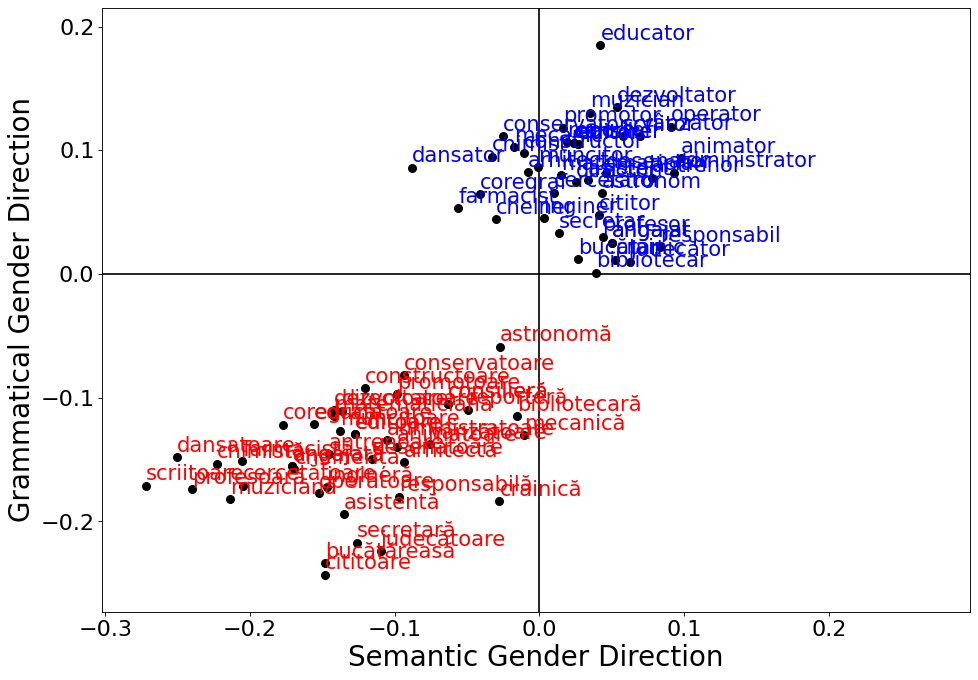

In [40]:
plot_on_both_dir_pairs(RO_occupation_pairs, romanian_embeddings, \
                       romanian_word2id, RO_semantic_gender_direction, RO_grammar_gender_direction_3000)

#Debias Experiments

##Bias Analysis-WE(F)AT

In [41]:
def modified_WEAT(embeddings, word2id, pairs, WEAT_male, WEAT_female):
    total_male_association = 0.0
    total_female_association = 0.0
    list_male = []
    list_female = []
    for pair in pairs:
        male_form = pair[0]
        female_form = pair[1]
        if male_form not in word2id or female_form not in word2id:
            continue
        male_male_cos = 0.0 # male form word cosine with male def word
        male_female_cos = 0.0
        female_male_cos = 0.0
        female_female_cos = 0.0
        for male_def in WEAT_male:
            male_male_cos += embeddings[word2id[male_def]].dot(embeddings[word2id[male_form]])
            female_male_cos += embeddings[word2id[male_def]].dot(embeddings[word2id[female_form]])
        for female_def in WEAT_female:
            female_female_cos += embeddings[word2id[female_def]].dot(embeddings[word2id[female_form]])
            male_female_cos += embeddings[word2id[female_def]].dot(embeddings[word2id[male_form]])
        
        list_male.append(embeddings[word2id[male_def]].dot(embeddings[word2id[male_form]]))
        list_female.append(embeddings[word2id[female_def]].dot(embeddings[word2id[female_form]]))

        male_male_cos /= len(WEAT_male)
        female_male_cos /= len(WEAT_male)
        male_female_cos /= len(WEAT_female)
        female_female_cos /= len(WEAT_female)
        male_form_association = male_male_cos - male_female_cos
        female_form_association = female_male_cos - female_female_cos

        total_male_association += male_form_association
        total_female_association += female_form_association
    print(cos_sim(list_male, list_female))
    return [total_male_association-total_female_association, abs(abs(total_male_association)-abs(total_female_association))]

In [42]:
RO_female_occupation_words = [pair[0] for pair in RO_occupation_pairs] 
RO_male_occupation_words = [pair[1] for pair in RO_occupation_pairs]

In [44]:
RO_male_occupation_words[:3]

['operator', 'angajat', 'director']

In [45]:
RO_WEAT_male = ["bărbat", "băiețel", "el", "tată", "fiu", "frate", "verișor", "nepot", "soț"]
RO_WEAT_female = ["femeie", "fetiță", "ea", "mamă", "fiică", "soră", "verișoară", "nepoată", "soție"]

In [48]:
embeddings = romanian_embeddings
word2id = romanian_word2id
WEAT_male = RO_WEAT_male
WEAT_female = RO_WEAT_female

print(modified_WEAT(embeddings, word2id, list(zip(RO_female_occupation_words, RO_male_occupation_words)), WEAT_male, WEAT_female))

0.9782117395407506
[-5.251877538823521, 2.5701470848651713]
